# Pipeline for prosthesis resizing to fit stump and electrodes

### Import the stump and socket, and create a point cloud

In [69]:
import open3d as o3d
import numpy as np

# Load the STL files for stump and socket
stump_mesh = o3d.io.read_triangle_mesh("stump.stl")
socket_mesh = o3d.io.read_triangle_mesh("socket.stl")

# Convert the meshes to point clouds for easier handling if necessary
stump_pcd = stump_mesh.sample_points_uniformly(number_of_points=3000)
socket_pcd = socket_mesh.sample_points_uniformly(number_of_points=3000)

# Visualize the initial stump and socket
o3d.visualization.draw_geometries([stump_mesh, socket_mesh], window_name="Initial Stump and Socket")


### Create random electrode positions (until william can provide us with actual ones)

In [70]:
import random as rand

desired_depth = -70 #This is the amount we need the stump to be in the socket

stump_points = np.array(stump_pcd.points)
electrode_positions = []
maximum_z_position = np.max(stump_points[:,2])
print(maximum_z_position)
while True: #select 3 random points on the stump:
    electrode_position_example = stump_points[rand.randint(0,2000)]
    if electrode_position_example[2] < maximum_z_position + desired_depth+ 10: #(let it be a bit above the bottom)
        continue
    else:
        electrode_positions.append(electrode_position_example)
    if len(electrode_positions) >= 6:
        break
electrode_positions_pcd = o3d.geometry.PointCloud()
electrode_positions_pcd.points = o3d.utility.Vector3dVector(electrode_positions)

o3d.visualization.draw_geometries([electrode_positions_pcd, stump_mesh], window_name="Initial Stump and Socket")




130.00000000000003


### Compute the centroids of the points, and place them all on top of each other. We also assume the electrodes are centered with respect to the stump mesh, so all the transformations to the stump also happen to the electrode positions

In [71]:
import copy

# Compute centroids
stump_center = stump_pcd.get_center()
socket_center = socket_pcd.get_center()

# Create deep copies of the original meshes for centered versions
centered_stump_mesh = copy.deepcopy(stump_mesh)
centered_socket_mesh = copy.deepcopy(socket_mesh)

# Create deep copies of the original meshes for centered versions
centered_stump_pcd = copy.deepcopy(stump_pcd)
centered_socket_pcd = copy.deepcopy(socket_pcd)
centered_electrode_positions_pcd = copy.deepcopy(electrode_positions_pcd)
centered_electrode_positions = copy.deepcopy(electrode_positions)


# Translate the copied meshes to center them
centered_stump_mesh.translate(-stump_center)
centered_socket_mesh.translate(-socket_center)

centered_stump_pcd.translate(-stump_center)
centered_socket_pcd.translate(-socket_center)
centered_electrode_positions_pcd.translate(-stump_center)

for point_index in range(len(centered_electrode_positions)):
    centered_electrode_positions[point_index]-=stump_center

    

# o3d.visualization.draw_geometries([centered_stump_pcd, centered_socket_pcd], window_name="Centered Stump and Socket")
o3d.visualization.draw_geometries([centered_stump_mesh, centered_electrode_positions_pcd, centered_socket_pcd], window_name="Centered Stump and Socket")


### Translate the stump and electrodes until you have a desired position you need

In [72]:
desired_depth = -70  # some amount of cm into the socket, can be changed 

# Find the Z-coordinate of the stump tip (lowest point in Z)
socket_bottom_z = np.min(np.asarray(centered_socket_pcd.points)[:, 2])
stump_bottom_z = np.min(np.asarray(centered_stump_pcd.points)[:, 2])
stump_top_z = np.max(np.asarray(centered_stump_pcd.points)[:, 2])
# print (socket_bottom_z, stump_bottom_z, stump_top_z)

# Calculate required translation along the Z-axis
current_difference_z = socket_bottom_z - stump_top_z
stump_translation_z = desired_depth-current_difference_z 

translated_and_centered_stump_pcd = copy.deepcopy(centered_stump_pcd)
translated_and_centered_stump_mesh = copy.deepcopy(centered_stump_mesh)
translated_and_centered_electrode_positions_pcd = copy.deepcopy(centered_electrode_positions_pcd)
translated_and_centered_electrode_positions = copy.deepcopy(centered_electrode_positions)

# Translate the stump along Z-axis
translated_and_centered_stump_pcd.translate([0, 0, -stump_translation_z])
translated_and_centered_stump_mesh.translate([0, 0, -stump_translation_z])  # Translate original mesh as well
for point_index in range(len(translated_and_centered_electrode_positions)):
    translated_and_centered_electrode_positions[point_index][2]-=stump_translation_z
    
# Create new point cloud for electrode positions
translated_and_centered_electrode_positions_pcd = o3d.geometry.PointCloud()
translated_and_centered_electrode_positions_pcd.points = o3d.utility.Vector3dVector(translated_and_centered_electrode_positions)

# Visualize the positioned stump within the socket
# o3d.visualization.draw_geometries([translated_and_centered_stump_pcd, centered_socket_pcd], window_name="Positioned Stump in Socket")
# o3d.visualization.draw_geometries([translated_and_centered_stump_pcd, centered_stump_pcd], window_name="Positioned Stump in Socket")
# o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, centered_socket_mesh], window_name="Positioned Stump in Socket")
o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, translated_and_centered_electrode_positions_pcd], window_name="Positioned Stump in Socket")


### Scale the stump, but leave the electrode positions as is for now

In [73]:
# Calculate center for scaling
# Here, we must calculate the maximum diameter, and scale until we scale by a certain factor
scaling_factor = 1.1 # Adjust to control gap size
scaled_vertices = []

scaled_stump_mesh = copy.deepcopy(translated_and_centered_stump_mesh)
stump_new_center = translated_and_centered_stump_pcd.get_center()

# Convert stump vertices to NumPy array for manipulation
stump_vertices = copy.deepcopy(np.asarray(scaled_stump_mesh.vertices))

# Scale non-electrode points outward from the center
for point in stump_vertices:
    direction = point - stump_new_center
    scaled_point = stump_new_center + direction * scaling_factor #Considers center to be 0,0,Z but check this
    scaled_vertices.append(scaled_point)

# Update stump mesh with scaled vertices for inner socket surface
scaled_stump_mesh.vertices = o3d.utility.Vector3dVector(scaled_vertices)

stump_bottom_z = np.min(np.asarray(translated_and_centered_stump_pcd.points)[:, 2])
stump_top_z = np.max(np.asarray(centered_stump_pcd.points)[:, 2])

scaled_stump_pcd = scaled_stump_mesh.sample_points_uniformly(number_of_points=3000)

# Visualize the scaled stump
o3d.visualization.draw_geometries([scaled_stump_pcd, translated_and_centered_stump_mesh, translated_and_centered_electrode_positions_pcd], window_name="Scaled Stump for Inner Socket Surface")


### Now, we want to scale the electrodes in the normal direction to the stump. So not out from the center, but rather the normal of the stump itself. 

We might run into issues here when we consider the possible peaks and valleys of the stump

In [82]:
import numpy as np
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
offset_distance = 2  # Adjust distance as needed, (user-defined parameter)

# Function to calculate normals and translate electrodes along the normal direction
def calculate_normals(mesh, electrode_points, neighbors=20):
    normals = []
    mesh_points = np.unique(np.asarray(mesh.vertices), axis = 0) #TODO: Re-look into this, we have more points than we have unique points for some reason
    nbrs = NearestNeighbors(n_neighbors=neighbors).fit(mesh_points)
    mesh_center = mesh.get_center()
    for point in electrode_points:
        _, indices = nbrs.kneighbors([point])

        # Compute normal as average cross-product of nearest neighbors
        v1 = mesh_points[indices[0][1]] - point
        v2 = mesh_points[indices[0][2]] - point
        normal = np.cross(v1, v2)
        
        if np.linalg.norm(normal)   != 0:
            normal /= np.linalg.norm(normal)  # Normalize the vector
    
        # If normal is inwards into the stump, then that means the new point is closer to the stump center, so we must take that into account
        # when we are calculating it. We need the electrode to move always OUTWARDS from the center!

        # Check if the normal is pointing inwards (toward the stump center)
        direction_to_center = mesh_center - point
        if np.dot(normal, direction_to_center) > 0:
            # If dot product is positive, the normal is pointing inward, so flip it
            normal = -normal
    
        normals.append(normal)
    return np.array(normals)


# Calculate normals at each electrode
normals = calculate_normals(translated_and_centered_stump_mesh, translated_and_centered_electrode_positions)

# Scale normals to create translated electrodes
scaled_electrodes = translated_and_centered_electrode_positions + normals * offset_distance

# Convert electrode positions to Open3D PointClouds for visualization
scaled_electrodes_pcd = o3d.geometry.PointCloud()
scaled_electrodes_pcd.points = o3d.utility.Vector3dVector(scaled_electrodes)


# UNCOMMENT THESE LINES ONLY FOR VISUALIZATION OF THE NORMALS!!!
# Create lines representing the normals
line_points = []
line_indices = []

for i, (start, normal) in enumerate(zip(translated_and_centered_electrode_positions, normals)):
    end = start + 10*normal * offset_distance  # End point of the normal vector line
    line_points.append(start)
    line_points.append(end)
    line_indices.append([2 * i, 2 * i + 1])

# Convert line points and indices to Open3D LineSet for visualization
line_points_o3d = o3d.utility.Vector3dVector(line_points)
line_indices_o3d = o3d.utility.Vector2iVector(line_indices)
normal_lines = o3d.geometry.LineSet(points=line_points_o3d, lines=line_indices_o3d)
normal_lines.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in range(len(line_indices))])  # Red color for normals

# Visualize the stump mesh, original electrode positions, translated electrode positions, and normal lines
o3d.visualization.draw_geometries(
    [scaled_stump_pcd,translated_and_centered_stump_mesh, translated_and_centered_electrode_positions_pcd, scaled_electrodes_pcd, normal_lines],
    window_name="Electrode Normals Visualization"
)


### Create them as cylinders to subtract them from the socket.


In [83]:
import open3d as o3d
import numpy as np

# Load the custom electrode shape from the STL file
electrode_mesh_template = o3d.io.read_triangle_mesh("electrode.stl")

# Function to align and place the electrode mesh at each scaled electrode position
def create_aligned_electrode_mesh(position, normal):

    # Create a copy of the electrode mesh template
    electrode_mesh = copy.deepcopy(electrode_mesh_template)
    
    # Align the electrode along the normal direction
    # Calculate the rotation matrix to align the z-axis with the normal vector
    z_axis = np.array([0, 0, 1])  # Assume the electrode points along z-axis by default
    rotation_axis = np.cross(z_axis, normal)
    rotation_angle = np.arccos(np.dot(z_axis, normal))
    
    if np.linalg.norm(rotation_axis) > 0:  # Avoid division by zero if no rotation is needed
        rotation_axis /= np.linalg.norm(rotation_axis)
        rotation_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * rotation_angle)
        electrode_mesh.rotate(rotation_matrix, center=(0, 0, 0))

    # Translate the aligned electrode to the specified position
    electrode_mesh.translate(position)

    return electrode_mesh

# Create the aligned electrode meshes at each scaled electrode position
aligned_electrodes = []
for position, normal in zip(scaled_electrodes, normals):
    aligned_electrode = create_aligned_electrode_mesh(position, normal)
    aligned_electrodes.append(aligned_electrode)

# Visualize the stump mesh, socket mesh, and aligned electrodes
o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, scaled_stump_pcd] + aligned_electrodes,
                                  window_name="Aligned Electrodes on Socket")


In [76]:
import trimesh

def o3d_to_trimesh(o3d_mesh):
    """Convert an Open3D TriangleMesh to a Trimesh mesh."""
    vertices = np.asarray(o3d_mesh.vertices)
    faces = np.asarray(o3d_mesh.triangles)
    return trimesh.Trimesh(vertices=vertices, faces=faces)

# Convert the socket, stump, and electrodes meshes
socket_trimesh = o3d_to_trimesh(centered_socket_mesh)
stump_trimesh = o3d_to_trimesh(scaled_stump_mesh)

# Combine electrode meshes into a single Trimesh object
electrode_trimeshes = [o3d_to_trimesh(electrode) for electrode in aligned_electrodes]
combined_stump_and_electrodes_trimesh = trimesh.util.concatenate(electrode_trimeshes + [stump_trimesh])

# Subtract the combined stump and electrodes from the socket
socket_with_holes = socket_trimesh.difference(combined_stump_and_electrodes_trimesh)

In [84]:

def trimesh_to_o3d(tri_mesh):
    """Convert a Trimesh mesh to an Open3D TriangleMesh."""
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(tri_mesh.vertices)
    mesh.triangles = o3d.utility.Vector3iVector(tri_mesh.faces)
    return mesh

# Convert the final socket with holes back to Open3D
final_socket_mesh = trimesh_to_o3d(socket_with_holes)
final_socket_pcd = final_socket_mesh.sample_points_uniformly(number_of_points=5000)

#Not quite sure whether we need to keep this line
# combined_stump_and_electrodes = stump_trimesh.union(combined_stump_and_electrodes_trimesh)

final_stump_mesh = trimesh_to_o3d(combined_stump_and_electrodes_trimesh)

o3d.visualization.draw_geometries([final_socket_pcd] + aligned_electrodes,
                                  window_name="Aligned Electrodes on Socket")


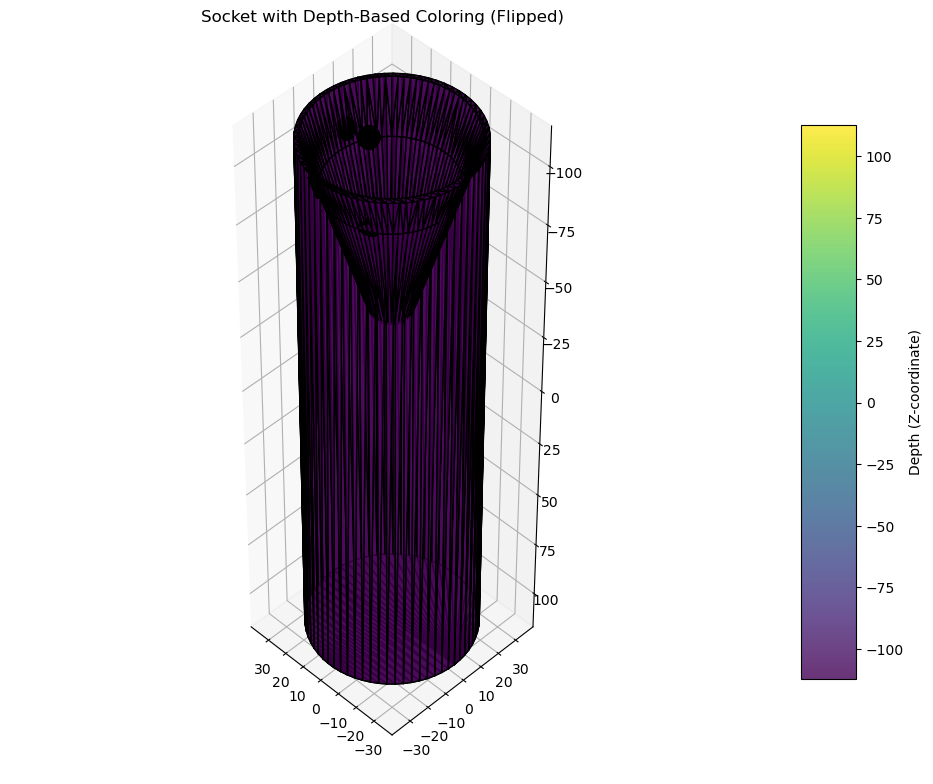

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract vertices and faces from the Trimesh mesh
vertices = socket_with_holes.vertices
faces = socket_with_holes.faces

# Plot with depth-based color
fig = plt.figure(figsize=(12, 12))  # Larger figure size
ax = fig.add_subplot(111, projection='3d')

# Create color mapping based on the Z-coordinate (depth) of each vertex
depth_colors = vertices[:, 2]  # Use Z-coordinate for color

# Plot the mesh with color based on depth
poly = ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces,
                       cmap='viridis', edgecolor='k', alpha=0.8, antialiased=True)
poly.set_array(depth_colors)

# Ensure equal scaling across all axes
ax.set_box_aspect([1, 1, 100/30])

# Flip the view upside down with a rotated perspective
ax.view_init(elev=180+45, azim=45)

# Add color bar for depth
fig.colorbar(poly, label='Depth (Z-coordinate)', shrink=0.6, aspect=10)
ax.set_title("Socket with Depth-Based Coloring (Flipped)")

plt.show()


C:\Users\karim\AppData\Local\Temp\ipykernel_26108\1079847117.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable, label='Depth (Z-coordinate)', shrink=0.6, aspect=10)


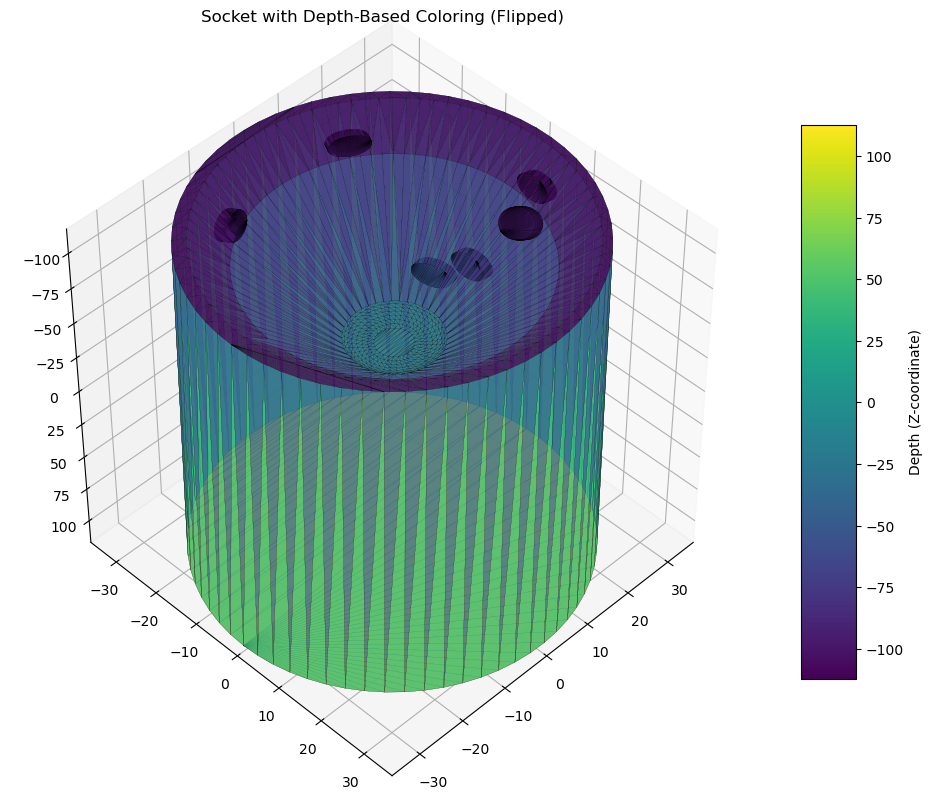

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Extract vertices and faces from the Trimesh mesh
vertices = socket_with_holes.vertices
faces = socket_with_holes.faces

# Set up figure and 3D axes
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Normalize depth (Z-coordinate) for colormap
depth_colors = vertices[:, 2]  # Use Z-coordinate for depth
norm = plt.Normalize(depth_colors.min(), depth_colors.max())
colors = plt.cm.viridis(norm(depth_colors))

# Prepare face colors based on average Z depth of each face
face_colors = []
for face in faces:
    # Calculate average Z-depth for each face
    avg_z = vertices[face, 2].mean()
    face_color = plt.cm.viridis(norm(avg_z))  # Map average Z to colormap
    face_colors.append(face_color)

# Create Poly3DCollection for mesh with depth-based face colors
mesh = Poly3DCollection(vertices[faces], facecolors=face_colors, edgecolor='k', linewidths=0.1, alpha=0.8)
ax.add_collection3d(mesh)

# Set equal scaling across all axes
ax.set_box_aspect([1, 1, 1])

# Flip the view upside down with a rotated perspective
ax.view_init(elev=180+45, azim=-45)

# Add color bar for depth
mappable = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
mappable.set_array(depth_colors)
fig.colorbar(mappable, label='Depth (Z-coordinate)', shrink=0.6, aspect=10)
ax.set_title("Socket with Depth-Based Coloring (Flipped)")

# Set axis limits based on vertex range for better visualization
ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())

plt.show()
